# Match Score Predictor

In this project I attempt to estimate the score of a match. Data is from cricsheet.

Relevent criteria:
    * Wickets in hand
    * Balls remaining
    * Current scores of batsmen
    * Strength of current batsmen
    * Runs scored last 5 overs

Additional useful criteria would be the strength of the bowlers in the opposing team (eg. runs conceded per wicket) and the strength of the batting lineup in the batting team (batting average, average strike rate). 

Due to the limitations in the data from cricsheet these statistics would be difficult to genrate. For example a complete batting lineup for each match is not available, just the players who have batted.

The project will be split into the following section

    1. Data exploration and cleaning
    2. Data selection
    3. Linear Regression modelling
    4. Random Forest Regression modelling
    5. XGboost modelling
    6. Conclusions

In [1]:
## import basic libraries

%matplotlib inline
import matplotlib

#basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pickle

sns.set(style="darkgrid")

## 1. Data Exploration and Manipulation

In [2]:
## load in the data

match_information = pd.read_csv(r'processed_data/match_information.csv')
batting_stats = pd.read_csv(r'processed_data/batting_stats.csv')
bowling_stats = pd.read_csv(r'processed_data/bowling_stats.csv')
ball_by_ball_stats = pd.read_csv(r'processed_data/ball_by_ball_stats.csv')

In [3]:
# aggregate mean statistics for batsmen

batsman_stats = batting_stats.groupby('batsman').agg({'runs':'sum','balls_faced':'sum','out':'sum'})
batsman_stats['average'] = batsman_stats['runs'] / batsman_stats['out']
batsman_stats['strike_rate'] = 100*batsman_stats['runs'] / batsman_stats['balls_faced']
batsman_stats['average'] = batsman_stats['average'].fillna(batsman_stats['runs'])
batsman_stats['average'] = batsman_stats['average'].replace(np.inf, batsman_stats['runs'])
batsman_stats.reset_index(inplace=True)

In [4]:
#relevant match statistics
stats = ball_by_ball_stats[['match_id','innings','batting_team','strike_batsman','offstrike_batsman','batsman_dismissed','over','runs','extras']]
#base_stats = stats.copy(deep=True) #copy of stats

#total number of runs for each innings in each match. 
#this will be used as a target for the model
score = stats[['match_id','innings','runs','extras']].groupby(['match_id','innings']).sum()
score.reset_index(inplace=True)
score['score'] = score['runs']+score['extras']

stats = pd.merge(stats, score[['match_id','innings','score']], how='left', on=(['match_id','innings']))


#Generate cumulative wickets down
stats['wickets'] = ~stats['batsman_dismissed'].isna()#.groupby(['match_id','innings']).cumsum()
stats['wickets'] = stats[['match_id','innings','wickets']].groupby(['match_id','innings']).cumsum().astype(int)
stats.drop(columns={'batsman_dismissed'}, inplace=True)


#Generate cumulative score, (runs + extras)
stats['cum_score'] = stats[['match_id','innings','runs','extras']].groupby(['match_id','innings']).cumsum().sum(axis=1)#\
           

    
#Generate cumulative score for striker and offstriker
    #first list generate cumulative scores for the batsman on strike

batsman_runs = stats[['match_id','runs','strike_batsman']].groupby(['match_id','strike_batsman']).agg({'runs':'cumsum'})

batsman_runs['strike_batsman'] = stats[['strike_batsman']]
batsman_runs['offstrike_runs'] = np.nan
batsman_runs['offstrike_batsman'] = stats[['offstrike_batsman']]
batsman_runs['match_id'] = stats[['match_id']]
    #list of strike batsmen
s = batsman_runs[['strike_batsman']].values
    #list of offstrike batsmen
os = batsman_runs[['offstrike_batsman']].values
#list of batsmen runs
s_runs = batsman_runs[['runs']].values[:,-1]
    #changes of strike (offstrike batsman was previous onstrike batsman)
ind = np.argwhere(s[:-1,0] == os[1:,0]) + 1

batsman_runs.loc[ind[:,0],'offstrike_runs'] = s_runs[ind -1]
batsman_runs['cum_offstrike_runs'] = batsman_runs[['match_id','offstrike_batsman','offstrike_runs']].groupby(['match_id','offstrike_batsman']).fillna(method = 'ffill')
batsman_runs.drop(columns=['offstrike_runs','match_id'], inplace=True)
batsman_runs['cum_offstrike_runs'].fillna(0, inplace=True) #fill remaining offstrike batsmen scores to zero
batsman_runs.rename(columns={'cum_offstrike_runs':'offstrike_runs','runs':'strike_runs'}, inplace=True)
    #append to stats (joining on index)
stats = stats.join(batsman_runs[['strike_runs','offstrike_runs']], how='left')


#eliminate extra balls ( > 6) in an over when an extra occurs. 
#Note in an over with a leg bye and a wide this may eliminate the leg bye. Unfortunately this is unavoidable since the 
#type of extra is not marked. Note that cumulative scores will remain unaffected by this process which essentially
#just adds to the cumulative score at intervals without affecting strike runs or offstrike runs

stats['over_number'] = np.ceil(stats['over']).astype(int)
stats['over_number'] = np.ceil(stats.over).astype(int)
stats_copy = stats.sort_values(['extras']).groupby(['match_id','innings','over_number']).head(6).sort_values(['match_id','innings','over'])
stats_copy['ball_count'] = stats_copy.groupby(['match_id','innings','over_number']).agg({'over_number':'cumcount'})+1
#evenly spread values in over (ie x.0, x.1/6, x.2/6, ... x.5/6)
stats_copy['over'] = (stats_copy['over_number']-1) + (stats_copy['ball_count'])*1/6
stats = stats_copy


#produce a rolling average of the number of runs scored in the past 5 overs
stats['run_past_5o'] = stats.runs.rolling(30).sum()

#add a run rate at which a team scores at for the remaining overs. This can act as a second target label
stats['rrate'] = (stats['score'] - stats['cum_score']) / (50 - stats['over'])



#filter for match ids with typical results (ie win/loss result and no D/L)
valid_match_ids = match_information[['match_id','outcome','method']].loc[(match_information['outcome'].isna()) & (match_information['method'].isna()) ]
    #apply filter
stats = stats.loc[stats['match_id'].isin(valid_match_ids['match_id'])]
stats = pd.merge(stats, match_information[['match_id','winner']], how='left', on='match_id')
stats['winner_bool'] = stats['batting_team'] == stats['winner']

## for rain (or delay) shortened matches find how many overs are bowled in the innings
# add the number of shortened overs to over number
stats1 = stats[stats['innings']==1]
target_scores = stats1[['match_id','score']].groupby('match_id').agg({'score':'first'})
target_scores.rename(columns={'score':'target_score'}, inplace=True)
x = stats1.groupby('match_id').max()[['over','wickets']]
y = x.loc[x['wickets'] != 10]
z = y.loc[y['over'] < 50]
q = z.loc[z['over'] == np.round(z['over'])]
q.reset_index(inplace=True)
filter_to_drop = stats['match_id'].isin(q['match_id'])
stats = stats[~filter_to_drop]

#drop 2nd innings which fall short of first innings target and 50 overs
stats2 = stats[stats['innings']==2].groupby('match_id').max()[['over','wickets','score']].reset_index()
x = pd.merge(stats2, target_scores, how='left', on='match_id')
y = x.loc[x['wickets'] != 10]
z = y.loc[y['over'] < 50]
q = z.loc[z.score < z.target_score]
q.reset_index(inplace=True)
filter_to_drop = stats['match_id'].isin(q['match_id'])
stats = stats[~filter_to_drop]



    
#remove the last ball from every innings since we cannot predict on the actual result
stats = stats.groupby(['match_id','innings']).apply(lambda x: x.iloc[:-1]).reset_index(drop=True)

In [5]:
##update stats_for_predictions
##this is used for score_predictor part 2
# pickle.dump(stats, open('stats_for_predictions.pkl','wb'))

## 2. Data Selection

In the previous section I produced a number of features on which to train a regression model. 

Target: 
score 
rrate

In terms of the predicted values the match score is the most straightforward an obvious target.  In the case where a poor regression model is used the predicted score may be wildly off even if there are only a few balls left in the match (or in some cases the predicted score may actually fall below the current cumulative score). For this reason I have also calculated rrate in the previous section. This is the run rate at which a team scores at for the remainder of the match. Since

    predicted score = predicted rrate * remaining overs + current score
    
The accuracy of the model will increase as the number of remaining overs decreases.


Features:

over
wickets
cum_score
strike_runs
offstrike_runs
runs_past_5o

_Innings_

To further narrow the selection of features I choose to use only the first innings of a match. This is because the first innings has only two termination conditions. Either 50 overs are reached or 10 wickets are taken. In the case when 10 wickets are taken the regressor can simply predict that no further runs are scored, and the remaining overs are virtually bowled out - leaving only 50 overs as a condition.

For the second inning the match can terminate in three ways. Firstly 50 overs are reached. Secondly 10 wickets are taken. Thirdly the score from the first innings is reached. 

In the second innings a teams scoring may be influenced by the first innings. For example if the first innings total is very small the team batting second may opt to score more safely at a slower rate, or more quickly knowing that victory is assured.

_Train Test Split_

In machine learning it is common to split the data into a training set and a testing set. This is useful because it can indicate cases where a model overfits the data. When this occurs the model may be simply memorising certain features corresponding to certain targets rather than working out useful general trends.

Rather than using an inbuilt train_test_split I choose to split the data by match number. Splitting rows at random means that a model may overfit by using information from a neighbouring row, which will be closely correlated. 

For example consider a predicted score of 300 at over 10 for some particular game. If a test case involves the predicting the total on the next ball the features will be nearly identical, and an overfitted model will produce good results.

To avoid this I will fit models on 75% of the matches, and keep 25% of the matches as test data.

In [5]:
#use data from only the first innings
data = stats.loc[stats['innings'] == 1]
data = data[:]

#split into training and testing data
np.random.seed(42)

test_size = 0.25
matches = data.match_id.unique()
number_of_matches = data.match_id.unique().shape[0]
test_matches = np.random.choice(matches, size = np.int(np.floor(number_of_matches * test_size)), replace=False)
train_matches = np.setdiff1d(matches, test_matches)

features = data[['over','wickets','cum_score','strike_runs','offstrike_runs']]

match_scores = data[['match_id','score']].groupby('match_id').agg('first')
match_scores.reset_index(inplace=True)

data_train = data.loc[data['match_id'].isin(train_matches)]
data_test = data.loc[data['match_id'].isin(test_matches)]

X_train_ = data_train[['over','wickets','cum_score','strike_runs','offstrike_runs']]
y_train = data_train[['score']]
y_train_r = data_train[['rrate']]


X_test_ = data_test[['over','wickets','cum_score','strike_runs','offstrike_runs']]
y_test = data_test[['score']]
y_test_r = data_test[['rrate']]


#apply a standard scaler to the features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train_.to_numpy())
X_test = sc.transform(X_test_.to_numpy())

X_full = features[:]
y_full = data[['score']]
y_full_r = data[['rrate']]

## 3. LinearRegression() model

As a preliminary exploration into fitting a model to this data I will look at the performance of sklearns LinearRegression model. This simple model generates a prediction based on linear scalings of each of the features. Since there is a lot of non-linear activity throughout a cricket match I do not expect a very good fit. 

I will use both the score and rrate as targets

### 3.1 Fitting the model

In [6]:
from sklearn.linear_model import LinearRegression

#instantiate
reg = LinearRegression()
reg_r = LinearRegression()

#fit
reg.fit(X_train,y_train)

#score
score = reg.score(X_test, y_test)
print('R2 score on match score = {:f}'.format(score))

#fit
reg_r.fit(X_train,y_train_r)

#score
score_r = reg_r.score(X_test, y_test_r)
print('R2 score on runrate = {:f}'.format(score_r))

#generate predictions

#pred_score = reg.predict(X_full)
#pred_r = reg_r.predict(X_full)
#pred_score_r = pred_r * (50-features.over) + features.cum_score

LinearRegPredictions = data_test[['match_id','over','score','wickets','cum_score']]


LinearRegPredictions = LinearRegPredictions[:]
LinearRegPredictions['pred_score'] = reg.predict(X_test)
LinearRegPredictions['error'] = LinearRegPredictions['pred_score'] - LinearRegPredictions['score']
LinearRegPredictions['pred_r'] = reg_r.predict(X_test)
LinearRegPredictions['pred_score_r'] = LinearRegPredictions['pred_r'] * (50-LinearRegPredictions.over) + LinearRegPredictions.cum_score
LinearRegPredictions['error_r'] = LinearRegPredictions['pred_score_r'] - LinearRegPredictions['score']

mean_rr = data[['match_id','score']].groupby(['match_id']).first().mean() / 50
LinearRegPredictions['error_mean_r'] =  mean_rr[0] * (50-LinearRegPredictions.over) + LinearRegPredictions.cum_score - LinearRegPredictions.score

LinearRegPredictions.head()


R2 score on match score = 0.547452
R2 score on runrate = 0.411406


match_id      over  score  wickets  cum_score  pred_score       error  \
1766    225249  0.166667    154        0          1  257.452184  103.452184   
1767    225249  0.333333    154        0          1  256.838184  102.838184   
1768    225249  0.500000    154        0          1  256.224184  102.224184   
1769    225249  0.666667    154        0          1  255.610183  101.610183   
1770    225249  0.833333    154        0          2  256.097780  102.097780   

        pred_r  pred_score_r    error_r  error_mean_r  
1766  4.649502    232.700159  78.700159     98.019391  
1767  4.653878    232.142590  78.142590     97.179862  
1768  4.658254    231.583561  77.583561     96.340332  
1769  4.662630    231.023074  77.023074     95.500802  
1770  4.691106    232.646069  78.646069     95.661272

In [7]:
#get list of Aussie matches in test samples
# match_list = LinearRegPredictions['match_id'].unique()
# data.loc[(data['match_id'].isin(match_list))  & (data['batting_team'] == 'Australia') &(data['over'] == 1)]

### 3.2 Match prediction

In this section I plot the predicted match scores against the actual match scores. I also highlight when wickets are taken, since this has a large impact on the predicted score (particularly early in the match).

[]

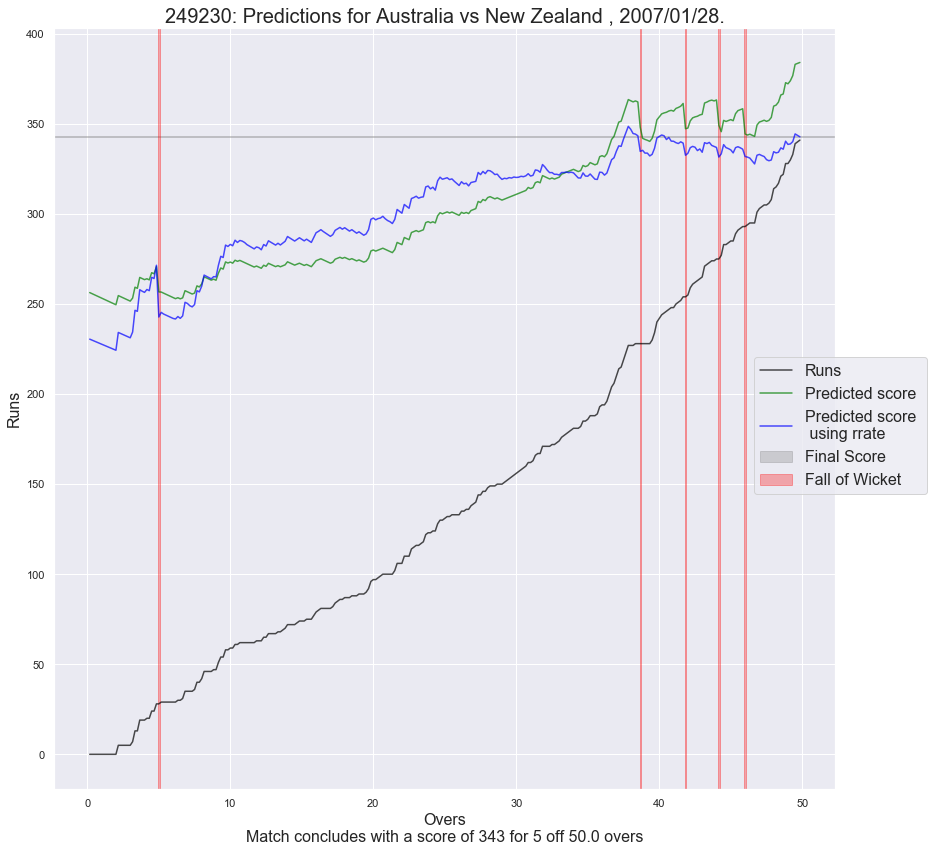

In [89]:
match_id = 249230

teams =  stats.loc[stats['match_id']==match_id].groupby('innings').agg({'batting_team':'first'}).reset_index()
batting_first = teams.loc[teams['innings']==1,'batting_team'][0]
batting_second= teams.loc[teams['innings']==2,'batting_team'][1]
date = match_information.loc[match_information['match_id'] == match_id,'start_date']
date = date.values[0]

MatchPredictions = LinearRegPredictions.loc[LinearRegPredictions['match_id'] == match_id]

score = MatchPredictions.iloc[0,:]['score']

fig, ax = plt.subplots(1,1, figsize=(14,14))

line1 = sns.lineplot(x='over', y='cum_score', data=MatchPredictions,ax=ax,color='black',alpha=0.7)

#plot match score prediction
line2 = sns.lineplot(x='over', y='pred_score', data=MatchPredictions, color='green',alpha=0.7)
#plot match score prediction based on rrate
line3 = sns.lineplot(x='over', y='pred_score_r', data=MatchPredictions, color='blue',alpha=0.7)

#plot the actual score as a horizontal line
ax.axhspan(score-0.25,score+0.25, alpha=0.3, color='grey')

# #plot when wickets are taken
fall_of_wicket = MatchPredictions[['wickets','over']].drop_duplicates('wickets',keep='first')
fall_of_wicket = fall_of_wicket.loc[:,'over'].values[1:]
for wicket in fall_of_wicket:
    ax.axvspan(wicket-0.05, wicket+0.05, alpha=0.3, color='red')

last_over = np.floor(MatchPredictions.over.max() + 1/6)
last_ball = ((MatchPredictions.over.max() + 1/6 % 1) - last_over) * 6/10
last = last_over + last_ball
    
#caption (text added below x label)
caption = 'Match concludes with a score of {} for {} off {} overs'.format(int(score),len(fall_of_wicket),last)

#label axes
ax.set_title('{}: Predictions for {} vs {} , {}.'.format(match_id,batting_first,batting_second,date), fontsize=20)
ax.set_xlabel('Overs' + '\n' + caption, fontsize=16)
ax.set_ylabel('Runs', fontsize=16)
fig.legend(labels=['Runs','Predicted score','Predicted score \n using rrate','Final Score','Fall of Wicket'], loc='center right', fontsize=16)
plt.plot()


### 3.3 Ensemble predictions 

In order to evaluate the performance of the model I plot the difference in predicted score against the actual score on an over by over basis. I compare this to the blind chance model, which simply predicts the average score of the match.

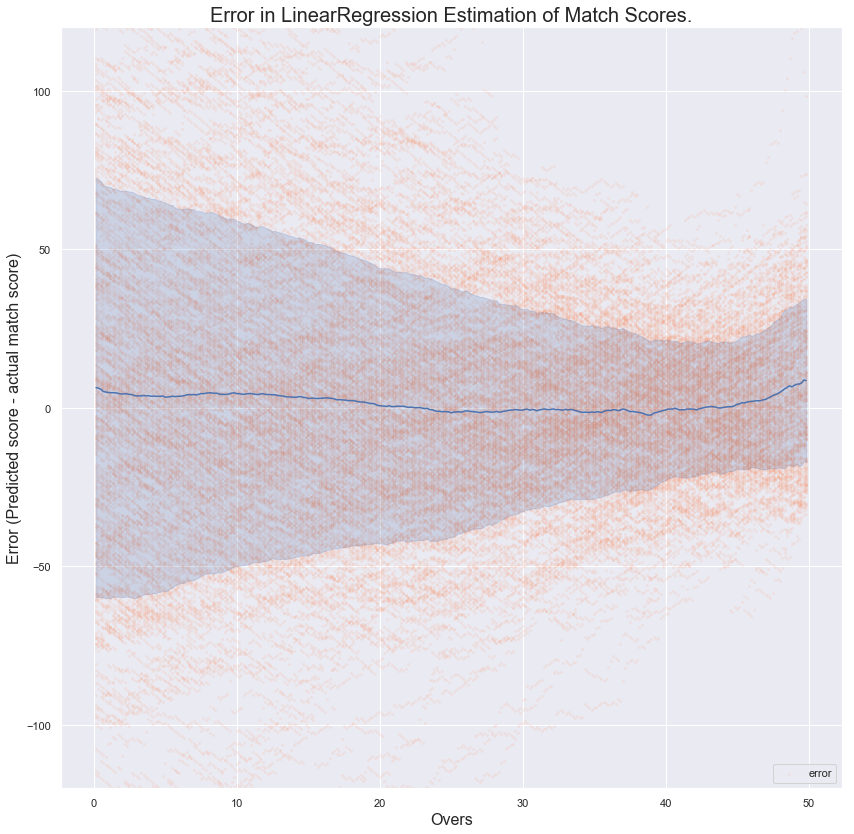

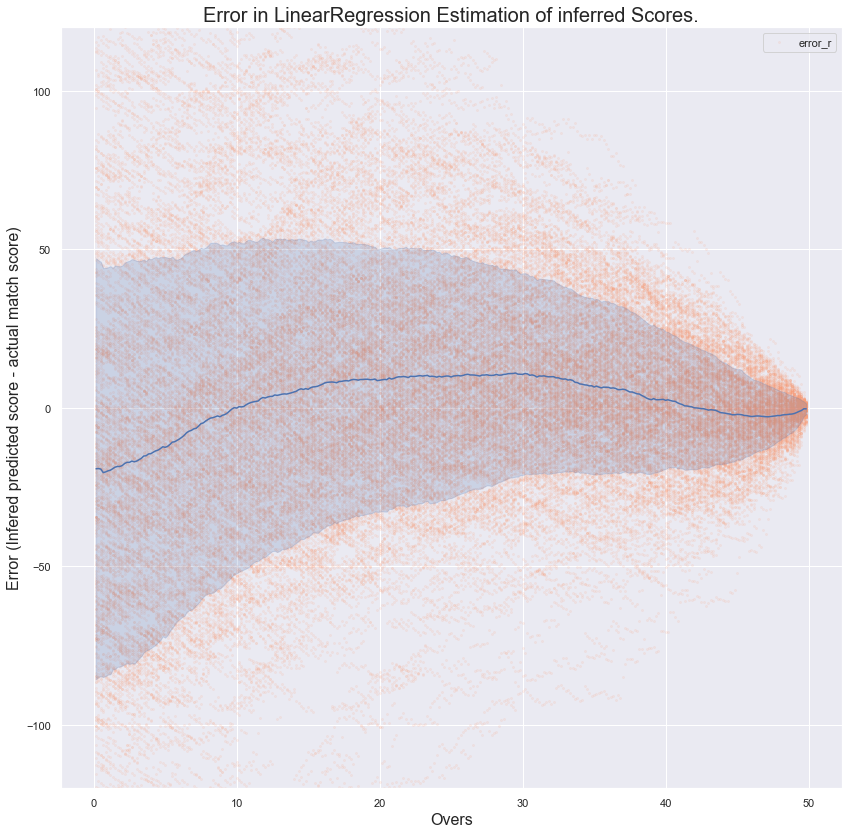

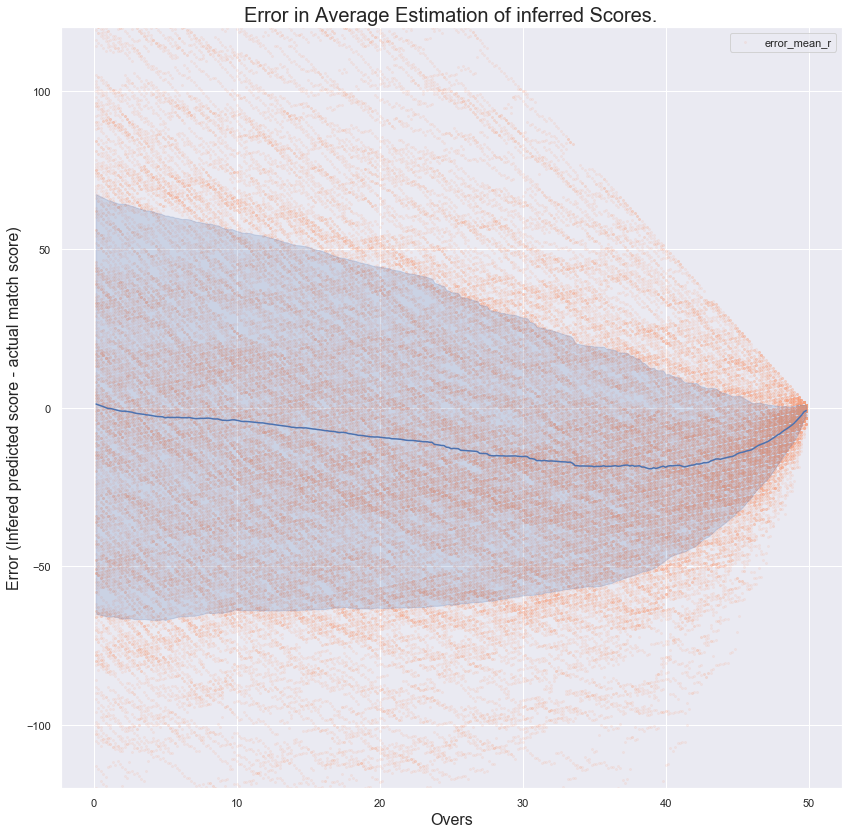

In [9]:
#First plot the regression model with the score as a target directly

fig, ax = plt.subplots(1,1, figsize=(14,14))

#plot the error in score estimation for the whole data set
plt.scatter(x='over', y='error', data=LinearRegPredictions,alpha=0.1, color='lightsalmon',s=4)
#plot a confidence interval of 1 standard deviation
sns.lineplot(x='over', y='error', data=LinearRegPredictions,ax=ax,alpha=1,ci='sd',err_style='band')

ax.set_ylim([-120,120])


ax.set_title('Error in LinearRegression Estimation of Match Scores.', fontsize=20)
ax.set_xlabel('Overs', fontsize=16)
ax.set_ylabel('Error (Predicted score - actual match score)', fontsize=16)
plt.show()


#plot the regression model with the score inferred from rrate

fig, ax2 = plt.subplots(1,1, figsize=(14,14))

#plot the error in score estimation for the whole data set
plt.scatter(x='over', y='error_r', data=LinearRegPredictions,alpha=0.1, color='lightsalmon',s=4)
#plot a confidence interval of 1 standard deviation
sns.lineplot(x='over', y='error_r', data=LinearRegPredictions,ax=ax2,alpha=1,ci='sd',err_style='band')

ax2.set_ylim([-120,120])


ax2.set_title('Error in LinearRegression Estimation of inferred Scores.', fontsize=20)
ax2.set_xlabel('Overs', fontsize=16)
ax2.set_ylabel('Error (Infered predicted score - actual match score)', fontsize=16)
plt.show()


#calculate the variance simply by predicting the score as
# predicted score = cumulative score + remaining_overs * global_average_runrate

mean_rr = data[['match_id','score']].groupby(['match_id']).first().mean() / 50
error_from_mean = mean_rr * (50-features.over) + features.cum_score


fig, ax3 = plt.subplots(1,1, figsize=(14,14))

#plot the error in score estimation for the whole data set
plt.scatter(x='over', y='error_mean_r', data=LinearRegPredictions,alpha=0.1, color='lightsalmon',s=4)
#plot a confidence interval of 1 standard deviation
sns.lineplot(x='over', y='error_mean_r', data=LinearRegPredictions,ax=ax3,alpha=1,ci='sd',err_style='band')

ax3.set_ylim([-120,120])


ax3.set_title('Error in Average Estimation of inferred Scores.', fontsize=20)
ax3.set_xlabel('Overs', fontsize=16)
ax3.set_ylabel('Error (Infered predicted score - actual match score)', fontsize=16)
plt.show()

#### 3.4 Remarks

From section 3.2 we can see that wickets greatly influence the predicted score. This has a particularly strong effect early in the match. The direct prediction of score and the inferred prediction of score are highly correlated in their fine features, with a general trend that the inferred score starts lower and eventually becomes higher. To see whether this is a general trend or just a trend which appears in this match we need to look at the ensemble of all matches played.

*Direct score prediction*

In section 3.3 ensemble predictions of all matches are illustrated. I note that the bias for the direct score estimation is fairly low, with the average error only a few runs above zero. 

The variance is quite high and approaches a minimum around 45 overs. This is interesting becuase one might expect that the variance should approach zero as the number of balls. This is   intuitive since the fewer balls that remain in the match, the smaller the possible range of scores there are. The linear model is not able to capture this behavior. It is likely that the model is trading off some inaccuracy in the final overs for a better fit throughout the rest of the data.



*Inferred score prediction*

The inferred score on the other hand has a bias which varies greatly as the match progresses. At the start of the match the average estimated score is around 25 runs below the actual score. The bias inverts in the middle overs, with the estimated score being over predicted. Towards the end the bias decreases and tends towards zero. 

The trend in the bias is likely due to how the runrate varies throughout a match. Typically the run rate is fairly high in the first 10 overs, where fielding restrictions encourage scoring. The run rate slows throughout the middle overs, then typically increases in the last 15 overs. The linear cannot cope with a variable which fluctutes in this way (does not vary linearly with number of overs). As such it makes a poor estimate as to how the over number affects the runrate. This leads to an underprediction in score at the start of the match (when the actual runrate is abnormally high) an overestimation throughout the middle of the match (when the actual runrate is low) and again underestimates in the last few overs when the runrate picks up again.

At the start of the match the variance of the models appear to be comparable. As the match progresses the variance of the infered model decreases monotomically. This is an expected consequence from how the score is predicted as the fewer remaining overs there are, the less the final score can vary.


*Estimation by average runrate*

Finally I have produced an estimated score which simply takes the avearage runrate across all matches and infers the score like the previous model. This approach does not use machine learning to predict the runrate any further and is used purely to contrast between the two methods. 

Due to the very high runrate at the end of matches compared to the start we see that this approach immediately produces undestimates of the match score as the match progresses (negative bias). The variance appears comparable with the inferred score prediction near the beginning of the match. This is expected. The variance decreases more slowly using the average runrate than it does using a linear model to predict run rate.


*Final thoughts*

A more complex model is required to encapsulate the dependence on run rate and scoring as a function of overs. There may also be more complex non linear behaviors which deal with the other features, such as the number of runs each batsman is on. It is reasonable that a batsman who has played themselves in, scoring 20 runs say, will be able to score at a faster rate than a batsman who has just come in (all other factors being equal). In the next sections I will look at fitting ensemble based regressors to the problem.

## 4. Random Forest Regressor 

In this section I will use sklearns RandromForestRegressor to estimate the scores of certain matches.


### 4.1 Fitting the model

In [10]:
from sklearn.ensemble import RandomForestRegressor

#instantiate
reg = RandomForestRegressor(n_estimators=400,max_depth=9, min_samples_leaf=5)
reg_r = RandomForestRegressor(n_estimators=400,max_depth=9, min_samples_leaf=5)

#fit
reg.fit(X_train,y_train)

#score
score = reg.score(X_test, y_test)
print('R2 score on match score = {:f}'.format(score))

#fit
reg_r.fit(X_train,y_train_r.to_numpy().ravel())

#score
score_r = reg_r.score(X_test, y_test_r.to_numpy().ravel())
print('R2 score on runrate = {:f}'.format(score_r))

#generate predictions

RandomForestPredictions = data_test[['match_id','over','score','wickets','cum_score']]


RandomForestPredictions = RandomForestPredictions[:]
RandomForestPredictions['pred_score'] = reg.predict(X_test)
RandomForestPredictions['error'] = RandomForestPredictions['pred_score'] - RandomForestPredictions['score']
RandomForestPredictions['pred_r'] = reg_r.predict(X_test)
RandomForestPredictions['pred_score_r'] = LinearRegPredictions['pred_r'] * (50-RandomForestPredictions.over) + RandomForestPredictions.cum_score
RandomForestPredictions['error_r'] = LinearRegPredictions['pred_score_r'] - RandomForestPredictions['score']

mean_rr = data[['match_id','score']].groupby(['match_id']).first().mean() / 50
RandomForestPredictions['error_mean_r'] =  mean_rr[0] * (50-RandomForestPredictions.over) + RandomForestPredictions.cum_score - LinearRegPredictions.score

RandomForestPredictions.head()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


R2 score on match score = 0.559060
R2 score on runrate = 0.447104


match_id      over  score  wickets  cum_score  pred_score      error  \
1766    225249  0.166667    154        0          1  249.574606  95.574606   
1767    225249  0.333333    154        0          1  249.574606  95.574606   
1768    225249  0.500000    154        0          1  249.574606  95.574606   
1769    225249  0.666667    154        0          1  249.528501  95.528501   
1770    225249  0.833333    154        0          2  249.464460  95.464460   

       pred_r  pred_score_r    error_r  error_mean_r  
1766  5.04038    232.700159  78.700159     98.019391  
1767  5.04038    232.142590  78.142590     97.179862  
1768  5.04038    231.583561  77.583561     96.340332  
1769  5.04038    231.023074  77.023074     95.500802  
1770  5.04038    232.646069  78.646069     95.661272

### 4.2 Match prediction

In this section I plot the predicted match scores against the actual match scores. I also highlight when wickets are taken, since this has a large impact on the predicted score (particularly early in the match).

[]

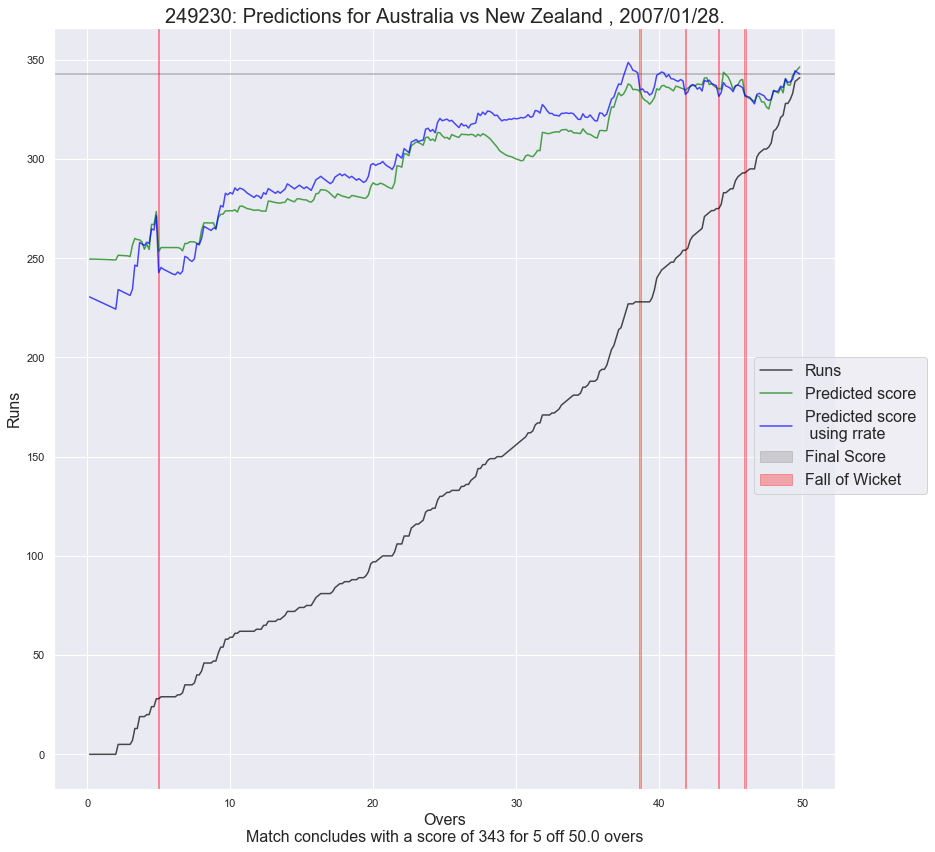

In [90]:
match_id = 249230

MatchPredictions = RandomForestPredictions.loc[RandomForestPredictions['match_id'] == match_id]

teams =  stats.loc[stats['match_id']==match_id].groupby('innings').agg({'batting_team':'first'}).reset_index()
batting_first = teams.loc[teams['innings']==1,'batting_team'][0]
batting_second= teams.loc[teams['innings']==2,'batting_team'][1]
date = match_information.loc[match_information['match_id'] == match_id,'start_date']
date = date.values[0]

score = MatchPredictions.iloc[0,:]['score']

fig, ax = plt.subplots(1,1, figsize=(14,14))

line1 = sns.lineplot(x='over', y='cum_score', data=MatchPredictions,ax=ax,color='black',alpha=0.7)

#plot match score prediction
line2 = sns.lineplot(x='over', y='pred_score', data=MatchPredictions, color='green',alpha=0.7)
#plot match score prediction based on rrate
line3 = sns.lineplot(x='over', y='pred_score_r', data=MatchPredictions, color='blue',alpha=0.7)

#plot the actual score as a horizontal line
ax.axhspan(score-0.25,score+0.25, alpha=0.3, color='grey')

# #plot when wickets are taken
fall_of_wicket = MatchPredictions[['wickets','over']].drop_duplicates('wickets',keep='first')
fall_of_wicket = fall_of_wicket.loc[:,'over'].values[1:]
for wicket in fall_of_wicket:
    ax.axvspan(wicket-0.05, wicket+0.05, alpha=0.3, color='red')

last_over = np.floor(MatchPredictions.over.max() + 1/6)
last_ball = ((MatchPredictions.over.max() + 1/6 % 1) - last_over) * 6/10
last = last_over + last_ball
    
#caption (text added below x label)
caption = 'Match concludes with a score of {} for {} off {} overs'.format(int(score),len(fall_of_wicket),last)

#label axes
ax.set_title('{}: Predictions for {} vs {} , {}.'.format(match_id,batting_first,batting_second,date), fontsize=20)
ax.set_xlabel('Overs' + '\n' + caption, fontsize=16)
ax.set_ylabel('Runs', fontsize=16)
fig.legend(labels=['Runs','Predicted score','Predicted score \n using rrate','Final Score','Fall of Wicket'], loc='center right', fontsize=16)
plt.plot()


### 4.3 Ensemble predictions 

In order to evaluate the performance of the model I plot the difference in predicted score against the actual score on an over by over basis. I compare this to the blind chance model, which simply predicts the average score of the match.

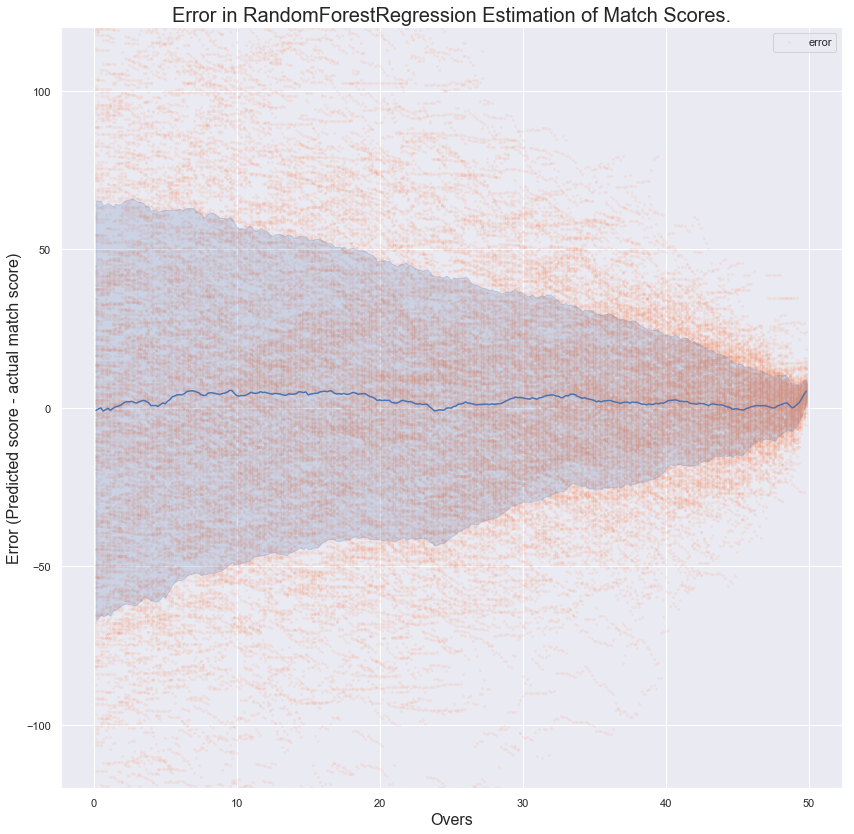

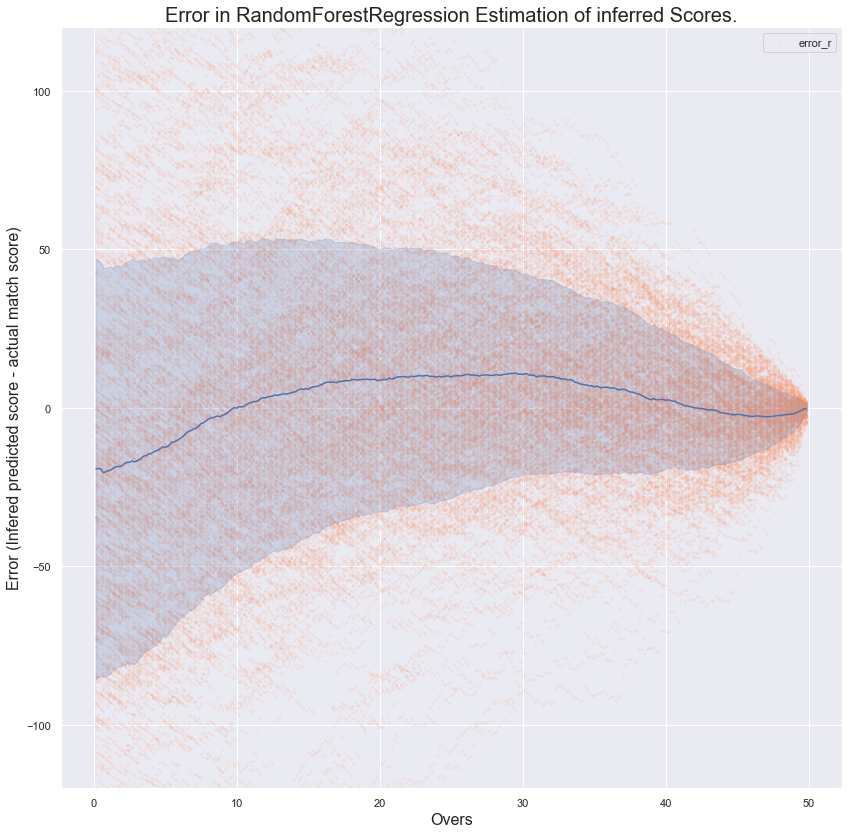

In [108]:
#First plot the regression model with the score as a target directly

fig, ax = plt.subplots(1,1, figsize=(14,14))

#plot the error in score estimation for the whole data set
plt.scatter(x='over', y='error', data=RandomForestPredictions,alpha=0.1, color='lightsalmon',s=4)
#plot a confidence interval of 1 standard deviation
sns.lineplot(x='over', y='error', data=RandomForestPredictions,ax=ax,alpha=1,ci='sd',err_style='band')

ax.set_ylim([-120,120])


ax.set_title('Error in RandomForestRegression Estimation of Match Scores.', fontsize=20)
ax.set_xlabel('Overs', fontsize=16)
ax.set_ylabel('Error (Predicted score - actual match score)', fontsize=16)
plt.show()


#plot the regression model with the score inferred from rrate

fig, ax2 = plt.subplots(1,1, figsize=(14,14))

#plot the error in score estimation for the whole data set
plt.scatter(x='over', y='error_r', data=RandomForestPredictions,alpha=0.1, color='lightsalmon',s=4)
#plot a confidence interval of 1 standard deviation
sns.lineplot(x='over', y='error_r', data=RandomForestPredictions,ax=ax2,alpha=1,ci='sd',err_style='band')

ax2.set_ylim([-120,120])


ax2.set_title('Error in RandomForestRegression Estimation of inferred Scores.', fontsize=20)
ax2.set_xlabel('Overs', fontsize=16)
ax2.set_ylabel('Error (Infered predicted score - actual match score)', fontsize=16)
plt.show()


## 5. Fitting over by over

It seems from the previous two sections that there is a significant bias which affects the models. This bias is dependent on the number of overs which have passed. In order to try and capture this behavior I will fit a model for each of the overs in a match, and restrict the training data to reflect this. The change in bias within a single over is much less significant than the change in bias seen throughout the entire match.

### 5.1 Fitting the data

In [87]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

load_precalculated = True

if load_precalculated == True:
    RandomForestOverPredictions = pickle.load(open("RandomForestOverPredictions.pkl",'rb'))
    LinearRegOverPredictions = pickle.load(open("LinearRegOverPredictions.pkl",'rb'))
    print('finished precalc loading')
else:

    RandomForestOverPredictions = data_test[['match_id','over','score','wickets','cum_score']]
    RandomForestOverPredictions = RandomForestOverPredictions[:]

#default N=2,  n_estimators = 100 for pre-calculated RandomForestOverPredictions


    LinearRegOverPredictions = data_test[['match_id','over','score','wickets','cum_score']]
    LinearRegOverPredictions = LinearRegOverPredictions[:]

# fit over by over with a window of N overs
    N = 2

    for over_number in data_train.over.unique():

    
    #predictions on score
        #train on a window around over_number
        X_train_o_ = X_train_.loc[np.abs(data_train.over - over_number) <= N]
        X_train_o = sc.fit_transform(X_train_o_.to_numpy())
        #test on over number
        X_test_o_ = X_test_.loc[data_test.over == over_number]
        X_test_o = sc.fit_transform(X_test_o_.to_numpy())
    
        y_train_o = y_train[np.abs(data_train.over - over_number) <= N]
        y_train_o = y_train_o.to_numpy().ravel()
        y_train_ro = y_train_r[np.abs(data_train.over - over_number) <= N]
        y_train_ro = y_train_ro.to_numpy().ravel()
        
    #regression directly on score
        reg = RandomForestRegressor(n_estimators=100,max_features=None)
        reg.fit(X_train_o,y_train_o) #fit all data within an over
    #updata values 
    #np ceil if running with an over window
        RandomForestOverPredictions.loc[(RandomForestOverPredictions.over)==over_number, 'pred_score'] = reg.predict(X_test_o)
    
    #regression on run rate
        reg_r = RandomForestRegressor(n_estimators=100,max_features=None)
        reg_r.fit(X_train_o,y_train_ro) #fit all data within an over
    #updata values 
        RandomForestOverPredictions.loc[(RandomForestOverPredictions.over)==over_number, 'pred_r'] = reg_r.predict(X_test_o)
    
        lin = LinearRegression()
        lin.fit(X_train_o,y_train_o)
    #update values
        LinearRegOverPredictions.loc[(LinearRegOverPredictions.over)==over_number, 'pred_score'] = lin.predict(X_test_o)
    
        lin = LinearRegression()
        lin.fit(X_train_o,y_train_ro)
    #update values
        LinearRegOverPredictions.loc[(LinearRegOverPredictions.over)==over_number, 'pred_r'] = lin.predict(X_test_o)
    
        display(over_number)

    
    RandomForestOverPredictions['error'] = RandomForestOverPredictions['pred_score'] - RandomForestOverPredictions['score']
    RandomForestOverPredictions['pred_score_r'] = RandomForestOverPredictions['pred_r'] *(50 - RandomForestOverPredictions.over) + RandomForestOverPredictions.cum_score
    RandomForestOverPredictions['error_r'] = RandomForestOverPredictions['pred_score_r'] - RandomForestOverPredictions['score']

    mean_rr = data[['match_id','score']].groupby(['match_id']).first().mean() / 50
    RandomForestOverPredictions['error_mean_r'] =  mean_rr[0] * (50-RandomForestOverPredictions.over) + RandomForestPredictions.cum_score - LinearRegPredictions.score
    
    LinearRegOverPredictions['error'] = LinearRegOverPredictions['pred_score'] - LinearRegOverPredictions['score']
    LinearRegOverPredictions['pred_score_r'] = LinearRegOverPredictions['pred_r'] *(50 - LinearRegOverPredictions.over) + LinearRegOverPredictions.cum_score
    LinearRegOverPredictions['error_r'] = LinearRegOverPredictions['pred_score_r'] - LinearRegOverPredictions['score']

    mean_rr = data[['match_id','score']].groupby(['match_id']).first().mean() / 50
    LinearRegOverPredictions['error_mean_r'] =  mean_rr[0] * (50-LinearRegOverPredictions.over) + LinearRegOverPredictions.cum_score - LinearRegOverPredictions.score



display(RandomForestOverPredictions.head())
display(LinearRegOverPredictions.head())

finished precalc loading


match_id      over  score  wickets  cum_score  pred_score    pred_r  \
1766    225249  0.166667    154        0          1  297.897500  6.048023   
1767    225249  0.333333    154        0          1  216.284218  4.343798   
1768    225249  0.500000    154        0          1  257.306523  5.150558   
1769    225249  0.666667    154        0          1  289.896558  5.890933   
1770    225249  0.833333    154        0          2  200.565071  4.061944   

           error  pred_score_r     error_r  error_mean_r  
1766  143.897500    302.393140  148.393140     98.019391  
1767   62.284218    216.741976   62.741976     97.179862  
1768  103.306523    255.952607  101.952607     96.340332  
1769  135.896558    291.619356  137.619356     95.500802  
1770   46.565071    201.712260   47.712260     95.661272

match_id      over  score  wickets  cum_score  pred_score    pred_r  \
1766    225249  0.166667    154        0          1  256.695081  5.138251   
1767    225249  0.333333    154        0          1  252.735228  5.097171   
1768    225249  0.500000    154        0          1  250.240960  5.072712   
1769    225249  0.666667    154        0          1  249.166757  5.073888   
1770    225249  0.833333    154        0          2  246.273858  5.078546   

           error  pred_score_r     error_r  error_mean_r  
1766  102.695081    257.056152  103.056152     98.019391  
1767   98.735228    254.159484  100.159484     97.179862  
1768   96.240960    252.099228   98.099228     96.340332  
1769   95.166757    251.311823   97.311823     95.500802  
1770   92.273858    251.695161   97.695161     95.661272

In [85]:
# #update RandomForestOverPredictions
# pickle.dump(RandomForestOverPredictions, open('RandomForestOverPredictions.pkl','wb'))

# #update RandomForestOverPredictions
# pickle.dump(LinearRegOverPredictions, open('LinearRegOverPredictions.pkl','wb'))

### 5.2 Match Predictions

[]

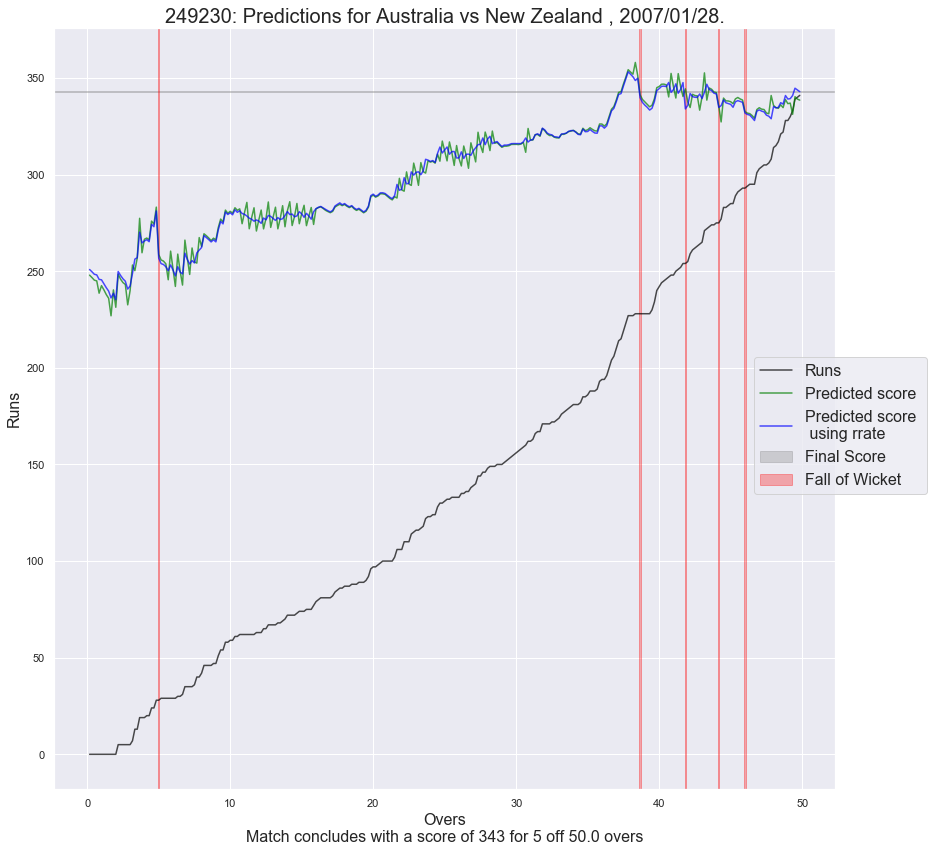

In [91]:
match_id = 249230

MatchPredictions = LinearRegOverPredictions.loc[LinearRegOverPredictions['match_id'] == match_id]

teams =  stats.loc[stats['match_id']==match_id].groupby('innings').agg({'batting_team':'first'}).reset_index()
batting_first = teams.loc[teams['innings']==1,'batting_team'][0]
batting_second= teams.loc[teams['innings']==2,'batting_team'][1]
date = match_information.loc[match_information['match_id'] == match_id,'start_date']
date = date.values[0]

score = MatchPredictions.iloc[0,:]['score']

fig, ax = plt.subplots(1,1, figsize=(14,14))

line1 = sns.lineplot(x='over', y='cum_score', data=MatchPredictions,ax=ax,color='black',alpha=0.7)

#plot match score prediction
line2 = sns.lineplot(x='over', y='pred_score', data=MatchPredictions, color='green',alpha=0.7)
#plot match score prediction based on rrate
line3 = sns.lineplot(x='over', y='pred_score_r', data=MatchPredictions, color='blue',alpha=0.7)

#plot the actual score as a horizontal line
ax.axhspan(score-0.25,score+0.25, alpha=0.3, color='grey')

# #plot when wickets are taken
fall_of_wicket = MatchPredictions[['wickets','over']].drop_duplicates('wickets',keep='first')
fall_of_wicket = fall_of_wicket.loc[:,'over'].values[1:]
for wicket in fall_of_wicket:
    ax.axvspan(wicket-0.05, wicket+0.05, alpha=0.3, color='red')

last_over = np.floor(MatchPredictions.over.max() + 1/6)
last_ball = ((MatchPredictions.over.max() + 1/6 % 1) - last_over) * 6/10
last = last_over + last_ball
    
#caption (text added below x label)
caption = 'Match concludes with a score of {} for {} off {} overs'.format(int(score),len(fall_of_wicket),last)

#label axes
ax.set_title('{}: Predictions for {} vs {} , {}.'.format(match_id,batting_first,batting_second,date), fontsize=20)
ax.set_xlabel('Overs' + '\n' + caption, fontsize=16)
ax.set_ylabel('Runs', fontsize=16)
fig.legend(labels=['Runs','Predicted score','Predicted score \n using rrate','Final Score','Fall of Wicket'], loc='center right', fontsize=16)
plt.plot()



### 5.3 Ensemble Predictions

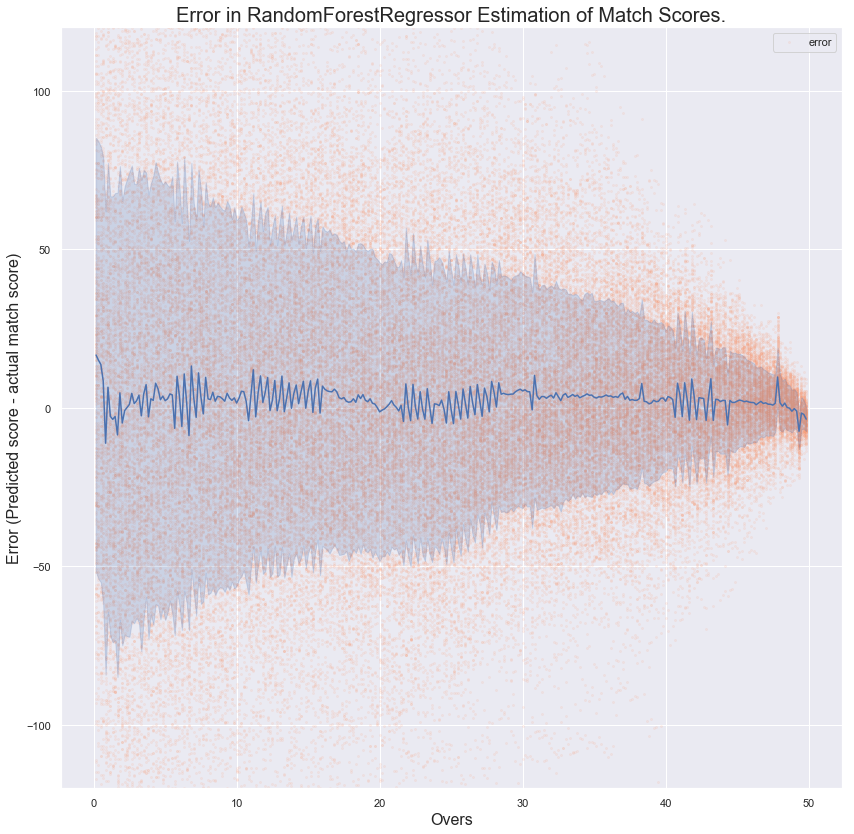

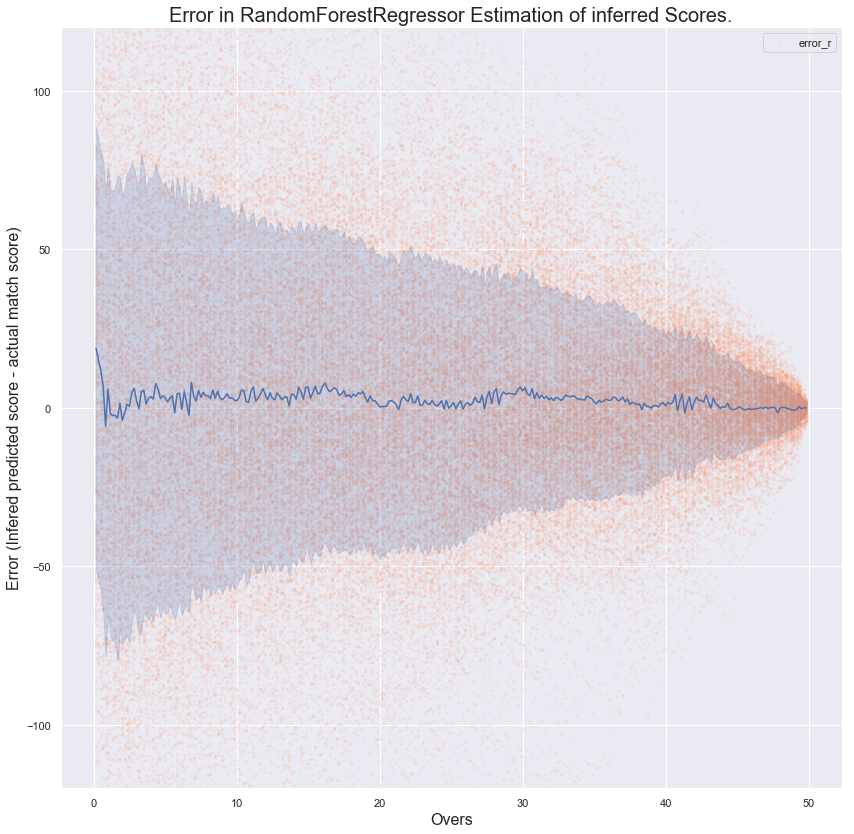

In [15]:
#First plot the regression model with the score as a target directly

fig, ax = plt.subplots(1,1, figsize=(14,14))

#plot the error in score estimation for the whole data set
plt.scatter(x='over', y='error', data=RandomForestOverPredictions,alpha=0.1, color='lightsalmon',s=4)
#plot a confidence interval of 1 standard deviation
sns.lineplot(x='over', y='error', data=RandomForestOverPredictions,ax=ax,alpha=1,ci='sd',err_style='band')

ax.set_ylim([-120,120])


ax.set_title('Error in RandomForestRegressor Estimation of Match Scores.', fontsize=20)
ax.set_xlabel('Overs', fontsize=16)
ax.set_ylabel('Error (Predicted score - actual match score)', fontsize=16)
plt.show()


#plot the regression model with the score inferred from rrate

fig, ax2 = plt.subplots(1,1, figsize=(14,14))

#plot the error in score estimation for the whole data set
plt.scatter(x='over', y='error_r', data=RandomForestOverPredictions,alpha=0.1, color='lightsalmon',s=4)
#plot a confidence interval of 1 standard deviation
sns.lineplot(x='over', y='error_r', data=RandomForestOverPredictions,ax=ax2,alpha=1,ci='sd',err_style='band')

ax2.set_ylim([-120,120])


ax2.set_title('Error in RandomForestRegressor Estimation of inferred Scores.', fontsize=20)
ax2.set_xlabel('Overs', fontsize=16)
ax2.set_ylabel('Error (Infered predicted score - actual match score)', fontsize=16)
plt.show()


#calculate the variance simply by predicting the score as
# predicted score = cumulative score + remaining_overs * global_average_runrate

mean_rr = data[['match_id','score']].groupby(['match_id']).first().mean() / 50
error_from_mean = mean_rr * (50-features.over) + features.cum_score


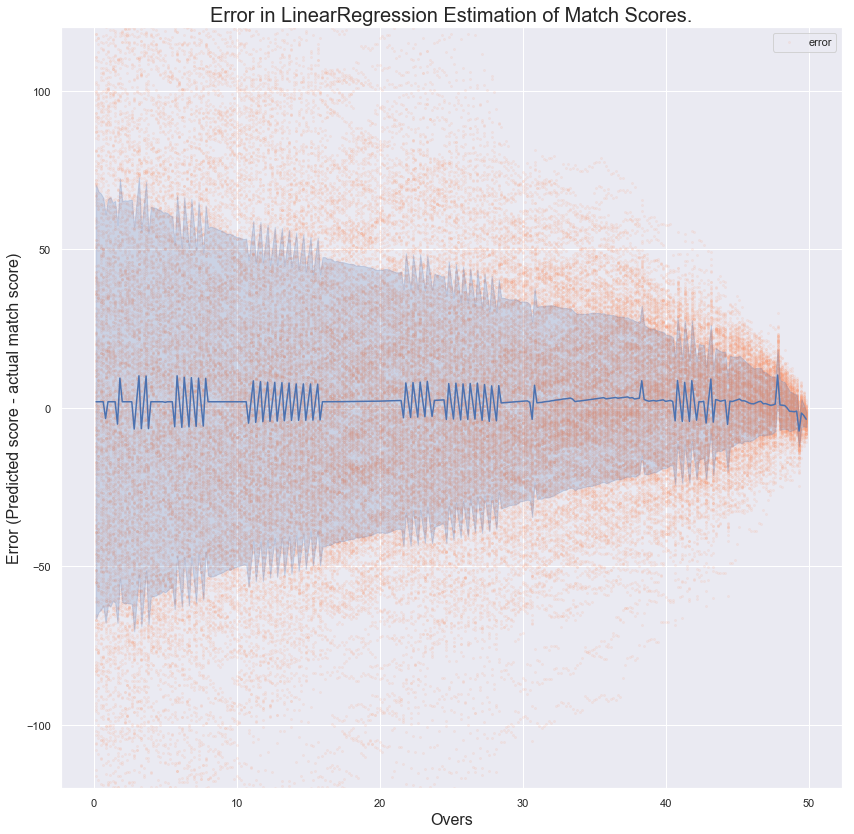

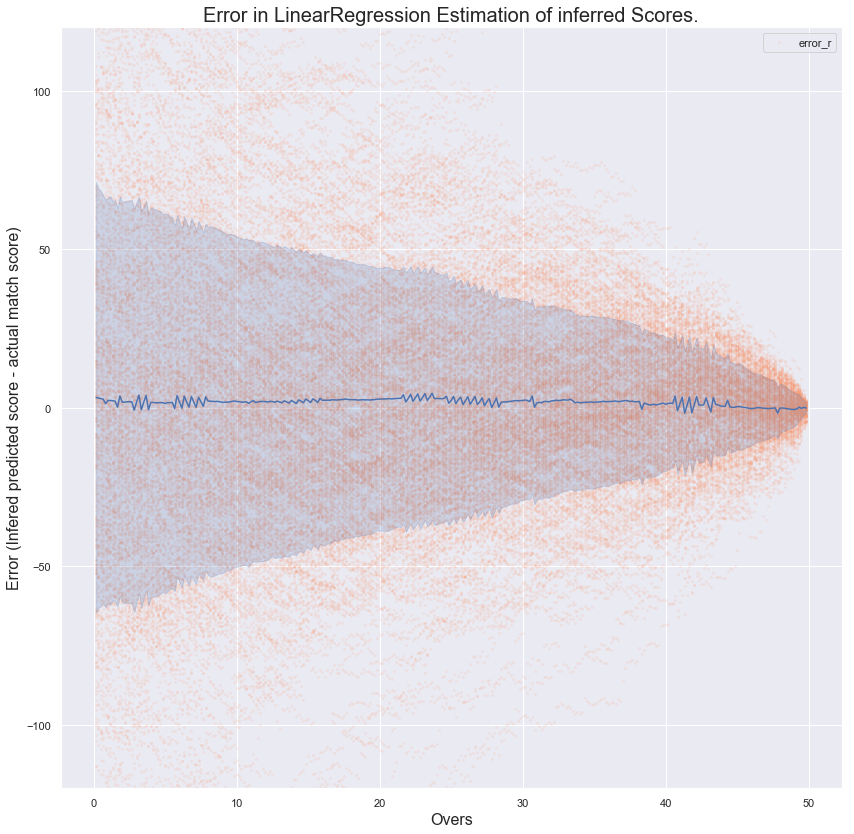

In [16]:
#First plot the regression model with the score as a target directly

fig, ax = plt.subplots(1,1, figsize=(14,14))

#plot the error in score estimation for the whole data set
plt.scatter(x='over', y='error', data=LinearRegOverPredictions,alpha=0.1, color='lightsalmon',s=4)
#plot a confidence interval of 1 standard deviation
sns.lineplot(x='over', y='error', data=LinearRegOverPredictions,ax=ax,alpha=1,ci='sd',err_style='band')

ax.set_ylim([-120,120])


ax.set_title('Error in LinearRegression Estimation of Match Scores.', fontsize=20)
ax.set_xlabel('Overs', fontsize=16)
ax.set_ylabel('Error (Predicted score - actual match score)', fontsize=16)
plt.show()


#plot the regression model with the score inferred from rrate

fig, ax2 = plt.subplots(1,1, figsize=(14,14))

#plot the error in score estimation for the whole data set
plt.scatter(x='over', y='error_r', data=LinearRegOverPredictions,alpha=0.1, color='lightsalmon',s=4)
#plot a confidence interval of 1 standard deviation
sns.lineplot(x='over', y='error_r', data=LinearRegOverPredictions,ax=ax2,alpha=1,ci='sd',err_style='band')

ax2.set_ylim([-120,120])


ax2.set_title('Error in LinearRegression Estimation of inferred Scores.', fontsize=20)
ax2.set_xlabel('Overs', fontsize=16)
ax2.set_ylabel('Error (Infered predicted score - actual match score)', fontsize=16)
plt.show()


#calculate the variance simply by predicting the score as
# predicted score = cumulative score + remaining_overs * global_average_runrate

mean_rr = data[['match_id','score']].groupby(['match_id']).first().mean() / 50
error_from_mean = mean_rr * (50-features.over) + features.cum_score


### 5.4 Remarks

It appears that RandomForstRegression produces poor results for this type of data set. The reason is likely due to the high variance within the data. I suspect this is especially true with wickets. The data is trained on 1000 matches. For a given over, for example the 10th over, there are only a certain number of matches in which 0 wickets or 1 wicket or 2 wickets etc. have been taken. Due to this I believe that the forest regression is overfitting by splitting on cases where a certain number of wickets are taken.

By contrast the linear regressor simply tries to work out a linear gradient with which each feature affects the target. As such when there are few samples with a given number of wickets taken (eg. 5 wickets taken in the 5th over) the effect of wickets may be extrapolated from cases where fewer wickets are taken. Of course the dependence is not likely to be entirely linear, but in the absence of a larger set of samples this is a decent estimate.

In section 5.2 I plot the match score estimation using a linear regression model. For each ball a new model is fitted on samples where the over is equal to the over of that ball, plus or minus two overs. In section 3.3 and 4.3 ensemble  predictions are shown for linear regression and random forest regression models. The bias with over number is quite large in both cases. In section 5.4 the ensemble predictions are shown for multiple models fit on windows of data around the over number. The variance does not seem to be substantially different, but the bias is much lower.

Using LinearRegression models with sliding window fitting seem to produce the best ensemble predictions. This will be used in the following section as a way of predicting match outcomes (win/loss) based on second innings match information. The bias in these predictions is likely due to the difference in the average scores of the training and test data sets. The average score in the test set is 249.54 and the average in the training set is 254.10, around 4.5 runs higher.


### 6. Fitting Window Regressor on full data set

In [17]:
#fit infered score predictions using runrate on rolling window of the dataset

from sklearn.linear_model import LinearRegression

LinearRegOverPredictionsFull = data[['match_id','over','score','wickets','cum_score']]
LinearRegOverPredictionsFull = LinearRegOverPredictionsFull[:]

# fit over by over with a window of N overs
N = 2


#X_full
#y_full

for over_number in data_train.over.unique():

    
    #predictions on score
        #train on a window around over_number
    X_train_o_ = X_full.loc[np.abs(X_full.over - over_number) <= N]
    X_train_o = sc.fit_transform(X_train_o_.to_numpy())
        #test on over number
    X_test_o_ = X_full.loc[X_full.over == over_number]
    X_test_o = sc.fit_transform(X_test_o_.to_numpy())
    
#     y_train_o = y_train[np.abs(data_train.over - over_number) <= N]
#     y_train_o = y_train_o.to_numpy().ravel()
    y_train_ro = y_full_r[np.abs(X_full.over - over_number) <= N]
    y_train_ro = y_train_ro.to_numpy().ravel()
        
    lin = LinearRegression()
    lin.fit(X_train_o,y_train_ro)
    #update values
    LinearRegOverPredictionsFull.loc[(LinearRegOverPredictionsFull.over)==over_number, 'pred_r'] = lin.predict(X_test_o)
    
    display(over_number)

    
LinearRegOverPredictionsFull['pred_score_r'] = LinearRegOverPredictionsFull['pred_r'] *(50 - LinearRegOverPredictionsFull.over) + LinearRegOverPredictionsFull.cum_score
LinearRegOverPredictionsFull['error_r'] = LinearRegOverPredictionsFull['pred_score_r'] - LinearRegOverPredictionsFull['score']

mean_rr = data[['match_id','score']].groupby(['match_id']).first().mean() / 50
LinearRegOverPredictionsFull['error_mean_r'] =  mean_rr[0] * (50-LinearRegOverPredictionsFull.over) + LinearRegOverPredictionsFull.cum_score - LinearRegOverPredictionsFull.score

LinearRegOverPredictionsFull.head()

0.16666666666666666

0.3333333333333333

0.5

0.6666666666666666

0.8333333333333334

1.0

1.1666666666666667

1.3333333333333333

1.5

1.6666666666666665

1.8333333333333335

2.0

2.1666666666666665

2.3333333333333335

2.5

2.6666666666666665

2.8333333333333335

3.0

3.1666666666666665

3.3333333333333335

3.5

3.6666666666666665

3.8333333333333335

4.0

4.166666666666667

4.333333333333333

4.5

4.666666666666667

4.833333333333333

5.0

5.166666666666667

5.333333333333333

5.5

5.666666666666667

5.833333333333333

6.0

6.166666666666667

6.333333333333333

6.5

6.666666666666667

6.833333333333333

7.0

7.166666666666667

7.333333333333333

7.5

7.666666666666667

7.833333333333333

8.0

8.166666666666666

8.333333333333334

8.5

8.666666666666666

8.833333333333334

9.0

9.166666666666666

9.333333333333334

9.5

9.666666666666666

9.833333333333334

10.0

10.166666666666666

10.333333333333334

10.5

10.666666666666666

10.833333333333334

11.0

11.166666666666666

11.333333333333334

11.5

11.666666666666666

11.833333333333334

12.0

12.166666666666666

12.333333333333334

12.5

12.666666666666666

12.833333333333334

13.0

13.166666666666666

13.333333333333334

13.5

13.666666666666666

13.833333333333334

14.0

14.166666666666666

14.333333333333334

14.5

14.666666666666666

14.833333333333334

15.0

15.166666666666666

15.333333333333334

15.5

15.666666666666666

15.833333333333334

16.0

16.166666666666668

16.333333333333332

16.5

16.666666666666668

16.833333333333332

17.0

17.166666666666668

17.333333333333332

17.5

17.666666666666668

17.833333333333332

18.0

18.166666666666668

18.333333333333332

18.5

18.666666666666668

18.833333333333332

19.0

19.166666666666668

19.333333333333332

19.5

19.666666666666668

19.833333333333332

20.0

20.166666666666668

20.333333333333332

20.5

20.666666666666668

20.833333333333332

21.0

21.166666666666668

21.333333333333332

21.5

21.666666666666668

21.833333333333332

22.0

22.166666666666668

22.333333333333332

22.5

22.666666666666668

22.833333333333332

23.0

23.166666666666668

23.333333333333332

23.5

23.666666666666668

23.833333333333332

24.0

24.166666666666668

24.333333333333332

24.5

24.666666666666668

24.833333333333332

25.0

25.166666666666668

25.333333333333332

25.5

25.666666666666668

25.833333333333332

26.0

26.166666666666668

26.333333333333332

26.5

26.666666666666668

26.833333333333332

27.0

27.166666666666668

27.333333333333332

27.5

27.666666666666668

27.833333333333332

28.0

28.166666666666668

28.333333333333332

28.5

28.666666666666668

28.833333333333332

29.0

29.166666666666668

29.333333333333332

29.5

29.666666666666668

29.833333333333332

30.0

30.166666666666668

30.333333333333332

30.5

30.666666666666668

30.833333333333332

31.0

31.166666666666668

31.333333333333332

31.5

31.666666666666668

31.833333333333332

32.0

32.166666666666664

32.333333333333336

32.5

32.666666666666664

32.833333333333336

33.0

33.166666666666664

33.333333333333336

33.5

33.666666666666664

33.833333333333336

34.0

34.166666666666664

34.333333333333336

34.5

34.666666666666664

34.833333333333336

35.0

35.166666666666664

35.333333333333336

35.5

35.666666666666664

35.833333333333336

36.0

36.166666666666664

36.333333333333336

36.5

36.666666666666664

36.833333333333336

37.0

37.166666666666664

37.333333333333336

37.5

37.666666666666664

37.833333333333336

38.0

38.166666666666664

38.333333333333336

38.5

38.666666666666664

38.833333333333336

39.0

39.166666666666664

39.333333333333336

39.5

39.666666666666664

39.833333333333336

40.0

40.166666666666664

40.333333333333336

40.5

40.666666666666664

40.833333333333336

41.0

41.166666666666664

41.333333333333336

41.5

41.666666666666664

41.833333333333336

42.0

42.166666666666664

42.333333333333336

42.5

42.666666666666664

42.833333333333336

43.0

43.166666666666664

43.333333333333336

43.5

43.666666666666664

43.833333333333336

44.0

44.166666666666664

44.333333333333336

44.5

44.666666666666664

44.833333333333336

45.0

45.166666666666664

45.333333333333336

45.5

45.666666666666664

45.833333333333336

46.0

46.166666666666664

46.333333333333336

46.5

46.666666666666664

46.833333333333336

47.0

47.166666666666664

47.333333333333336

47.5

47.666666666666664

47.833333333333336

48.0

48.166666666666664

48.333333333333336

48.5

48.666666666666664

48.833333333333336

49.0

49.166666666666664

49.333333333333336

49.5

49.666666666666664

49.833333333333336

match_id      over  score  wickets  cum_score    pred_r  pred_score_r  \
0    225171  0.166667    301        0          0  5.055950    251.954857   
1    225171  0.333333    301        0          0  5.048854    250.759736   
2    225171  0.500000    301        0          4  5.265252    264.629984   
3    225171  0.666667    301        0          6  5.345227    269.697873   
4    225171  0.833333    301        0          6  5.245409    263.899282   

     error_r  error_mean_r  
0 -49.045143    -49.980609  
1 -50.240264    -50.820138  
2 -36.370016    -47.659668  
3 -31.302127    -46.499198  
4 -37.100718    -47.338728

[]

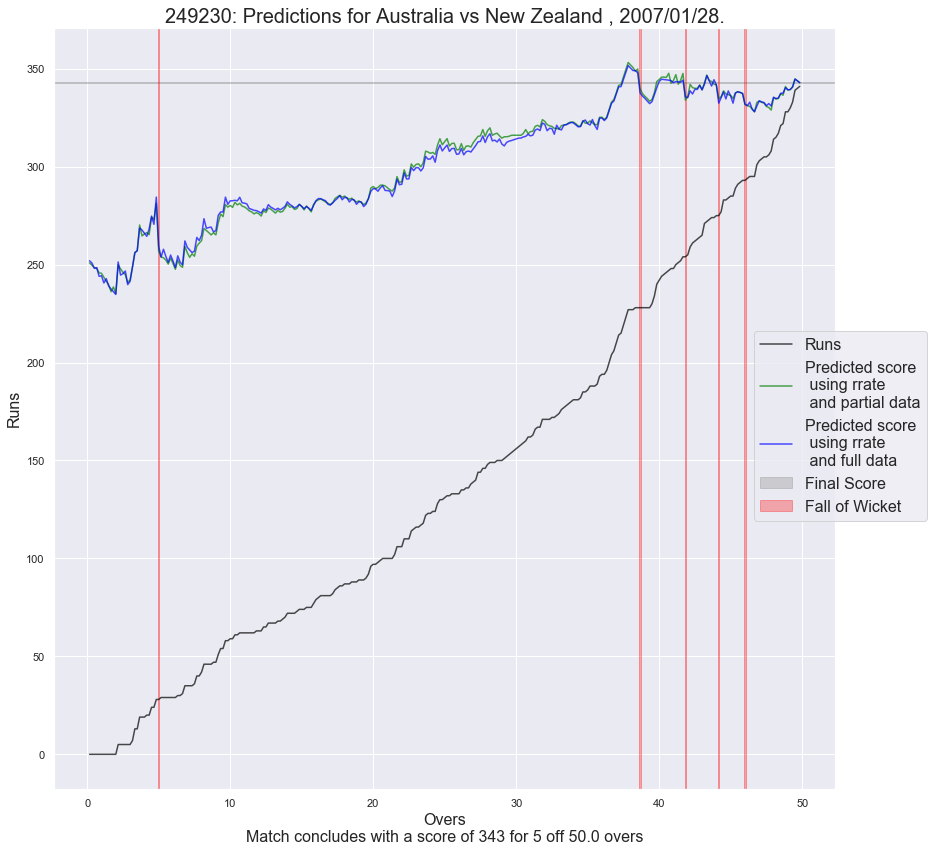

In [95]:
match_id = 249230

#RandomForestOverPredictions
#LinearRegOverPredictions

MatchPredictions = LinearRegOverPredictionsFull.loc[LinearRegOverPredictionsFull['match_id'] == match_id]
MatchPredictions_partial = LinearRegOverPredictions.loc[LinearRegOverPredictions['match_id'] == match_id]

teams =  stats.loc[stats['match_id']==match_id].groupby('innings').agg({'batting_team':'first'}).reset_index()
batting_first = teams.loc[teams['innings']==1,'batting_team'][0]
batting_second= teams.loc[teams['innings']==2,'batting_team'][1]
date = match_information.loc[match_information['match_id'] == match_id,'start_date']
date = date.values[0]

score = MatchPredictions.iloc[0,:]['score']

fig, ax = plt.subplots(1,1, figsize=(14,14))

line1 = sns.lineplot(x='over', y='cum_score', data=MatchPredictions,ax=ax,color='black',alpha=0.7)

#plot match score prediction
line2 = sns.lineplot(x='over', y='pred_score_r', data=MatchPredictions_partial, color='green',alpha=0.7)
#plot match score prediction based on rrate
line3 = sns.lineplot(x='over', y='pred_score_r', data=MatchPredictions, color='blue',alpha=0.7)

#plot the actual score as a horizontal line
ax.axhspan(score-0.25,score+0.25, alpha=0.3, color='grey')

# #plot when wickets are taken
fall_of_wicket = MatchPredictions[['wickets','over']].drop_duplicates('wickets',keep='first')
fall_of_wicket = fall_of_wicket.loc[:,'over'].values[1:]
for wicket in fall_of_wicket:
    ax.axvspan(wicket-0.05, wicket+0.05, alpha=0.3, color='red')

last_over = np.floor(MatchPredictions.over.max() + 1/6)
last_ball = ((MatchPredictions.over.max() + 1/6 % 1) - last_over) * 6/10
last = last_over + last_ball
    
#caption (text added below x label)
caption = 'Match concludes with a score of {} for {} off {} overs'.format(int(score),len(fall_of_wicket),last)

#label axes
ax.set_title('{}: Predictions for {} vs {} , {}.'.format(match_id,batting_first,batting_second,date), fontsize=20)
ax.set_xlabel('Overs' + '\n' + caption, fontsize=16)
ax.set_ylabel('Runs', fontsize=16)
fig.legend(labels=['Runs','Predicted score \n using rrate \n and partial data','Predicted score \n using rrate \n and full data','Final Score','Fall of Wicket'], loc='center right', fontsize=16)
plt.plot()



### 6.3 Ensemble predictions

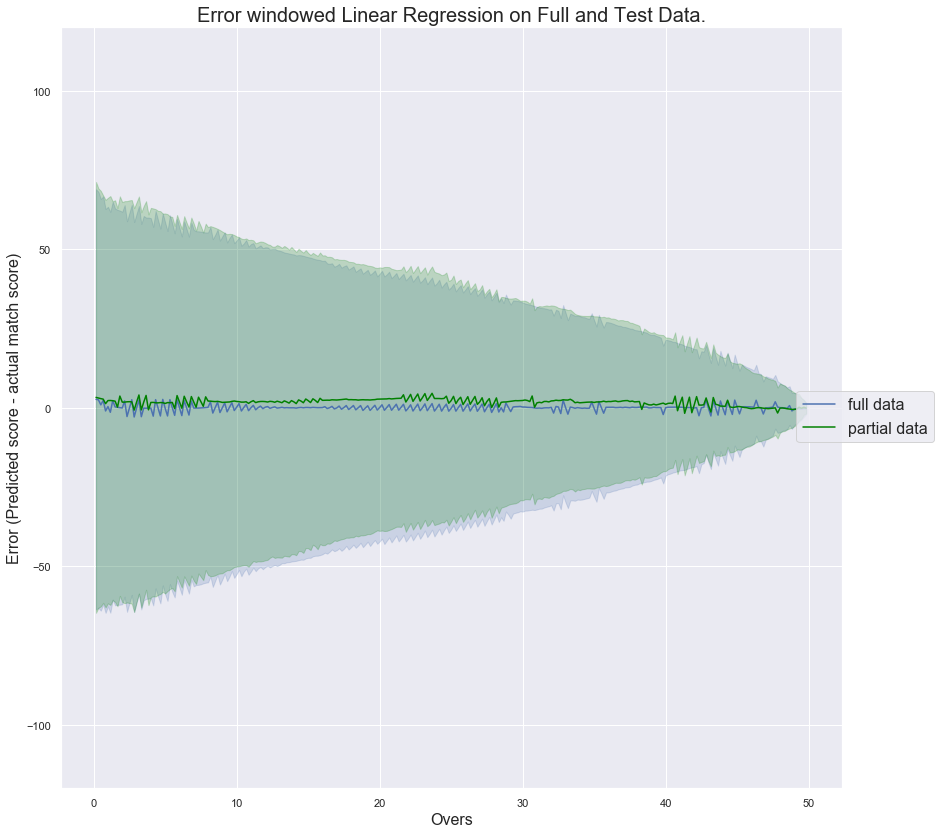

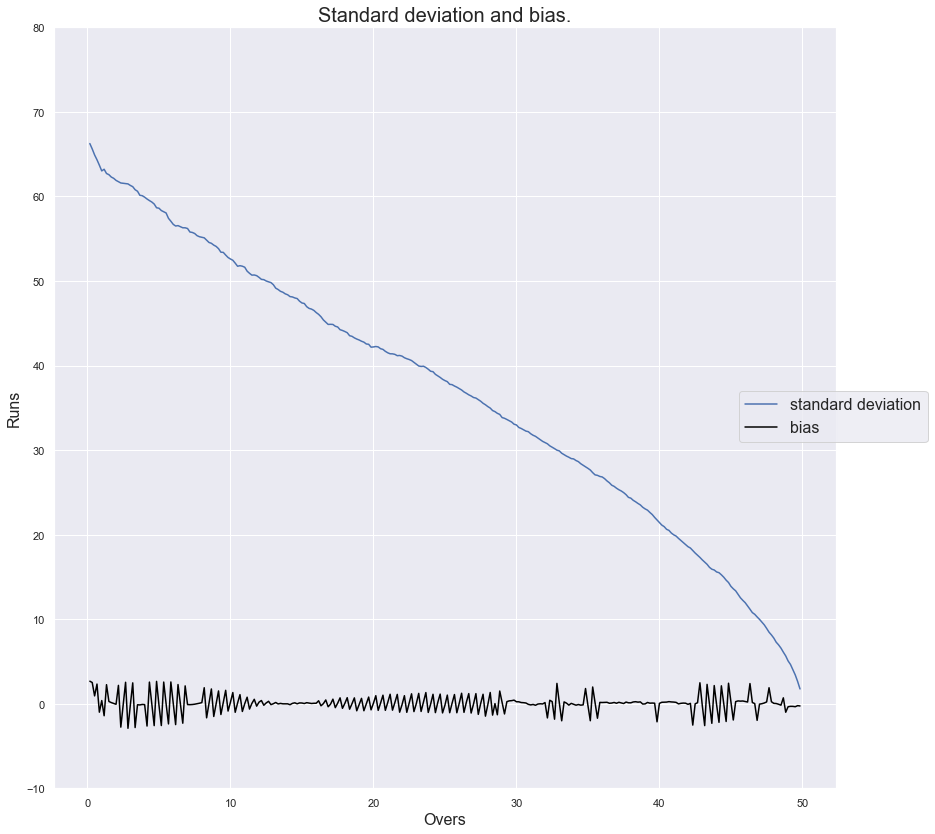

In [104]:
#First plot the regression model with the score as a target directly

fig, ax = plt.subplots(1,1, figsize=(14,14))

#plot the error in score estimation for the whole data set
#plt.scatter(x='over', y='error', data=LinearRegOverPredictionsFull,alpha=0.1, color='lightsalmon',s=4)
#plot a confidence interval of 1 standard deviation
sns.lineplot(x='over', y='error_r', data=LinearRegOverPredictionsFull,ax=ax,alpha=1,ci='sd',err_style='band')

sns.lineplot(x='over', y='error_r', data=LinearRegOverPredictions, ax=ax, alpha=1,ci='sd',err_style='band', color='green')

ax.set_ylim([-120,120])
fig.legend(labels=['full data','partial data'], loc='center right', fontsize=16)
ax.set_title('Error windowed Linear Regression on Full and Test Data.', fontsize=20)
ax.set_xlabel('Overs', fontsize=16)
ax.set_ylabel('Error (Predicted score - actual match score)', fontsize=16)
plt.show()


#
std = LinearRegOverPredictionsFull.groupby('over').std().reset_index()[['over','error_r']]
avg = LinearRegOverPredictionsFull.groupby('over').mean().reset_index()[['over','error_r']]

fig, ax2 = plt.subplots(1,1, figsize=(14,14))


sns.lineplot(x='over', y='error_r', data=std,ax=ax2)
sns.lineplot(x='over', y='error_r', data=avg,ax=ax2,color='black')

ax2.set_ylim([-10,80])
fig.legend(labels=['standard deviation','bias'], loc='center right', fontsize=16)
ax2.set_title('Standard deviation and bias.', fontsize=20)
ax2.set_xlabel('Overs', fontsize=16)
ax2.set_ylabel('Runs', fontsize=16)


plt.show()

### 6.4 Remarks

Training on the full dataset produces models which make predictions with a bias which appears centred around zero with respect to the number of overs bowled. This is an improvement over the model fitted on a partial set of data. Overfitting is unlikely to occur since the linear model has relatively few degrees of freedom (number of features = 5) compared to the number of samples for each sub model (number of balls in window size * number of matches > 1000).



## 7. Match Predictions

(continued in score_predictor part 2)

In this section I will create a model which will give match predictions based on an in-progress second innings. Essentially this involves determining whether the predicted score of the team batting second is greater than the actual score of the team batting first. The probability of winning or losing will be determined by the confidence intervals around the predicted score. 

This can be seen visually in the graph in sub section 6.3. If the team batting first has a score which lies 25 runs below the predicted score of the team batting second in the 40th over then the second team has about an 84% chance of winning. This is because the score of the team batting first lies approximately on the lower confidence interval, which is set at 1 standard deviation. The confidence interval contains around 68% of the results, with 16% lying below and 16% above. Only results which lie below result in a loss, so the team batting second has a 84% chance of winning.
